# We learn how to generate a graph minor on chemical structure graphs

#### this time we use learned abstraction.   which means that we try to cluster the parts that get contracted in the minor and use the cluster_id as the name of a minor vertex

#### initialise nb

In [12]:
%load_ext autoreload
%autoreload 2
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style>')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
%matplotlib inline

In [14]:
# get data
from eden.converter.graph.gspan import gspan_to_eden
from itertools import islice

def get_graphs(dataset_fname='../toolsdata/bursi.pos.gspan', size=100):
    return  islice(gspan_to_eden(dataset_fname),size)


# demonstration of the preprocesor learning the abstraction

cluster id: 0  num: 83


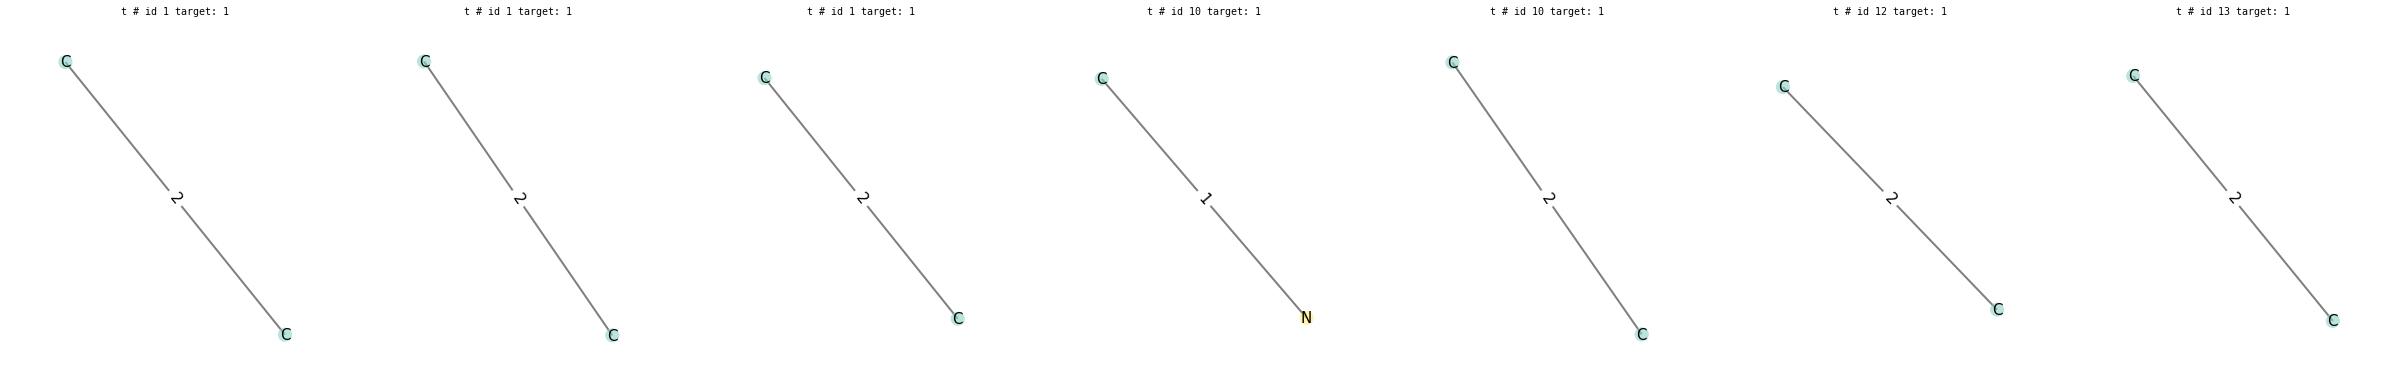

cluster id: 1  num: 23


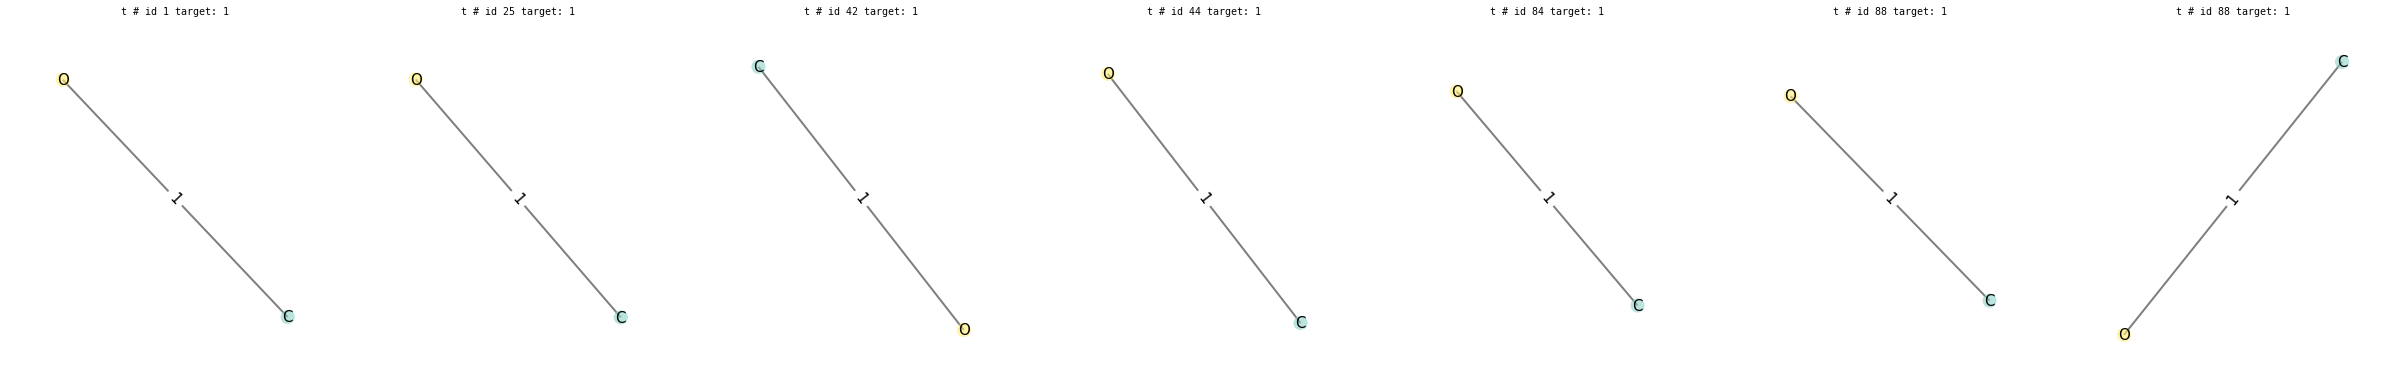

cluster id: 2  num: 85


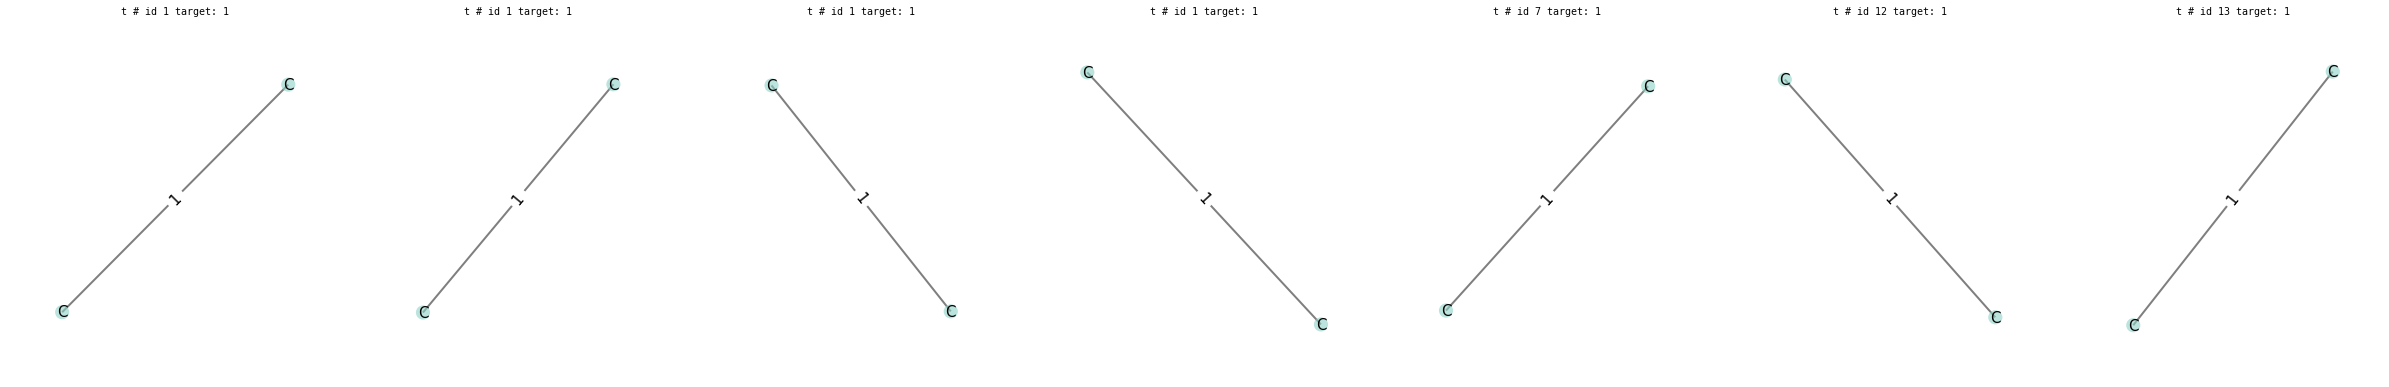

cluster id: 3  num: 130


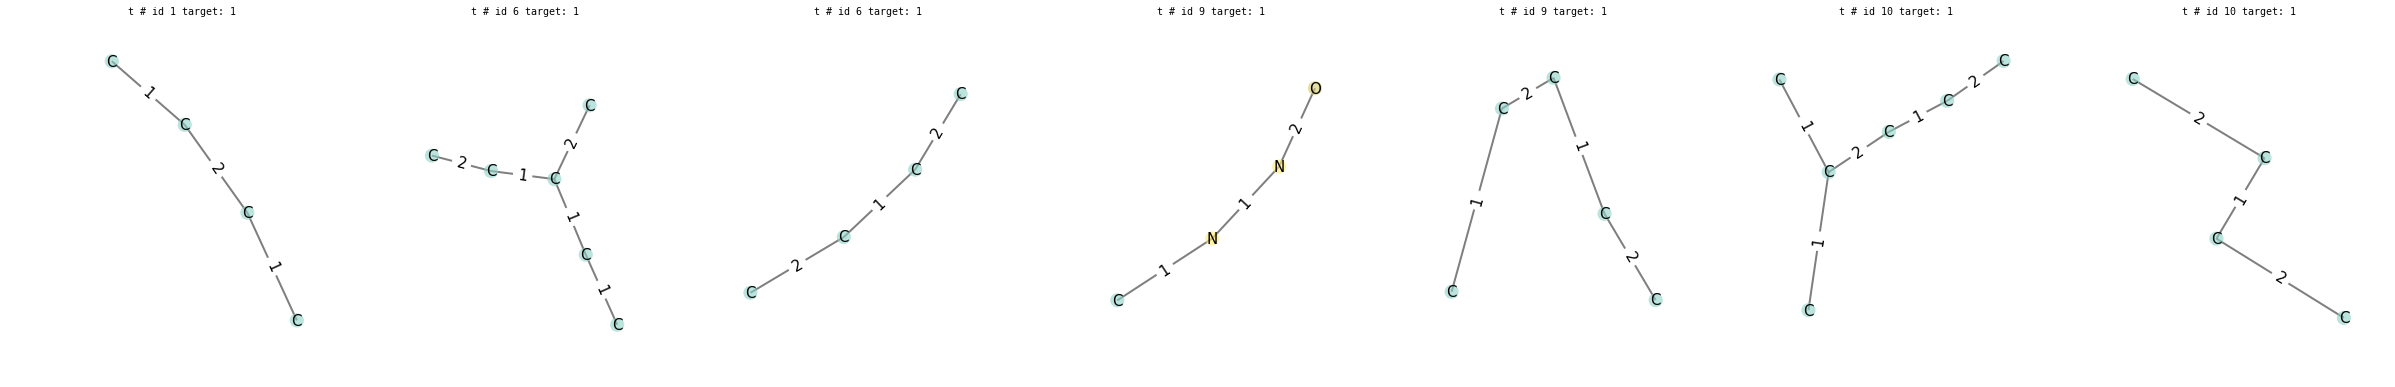

cluster id: 4  num: 46


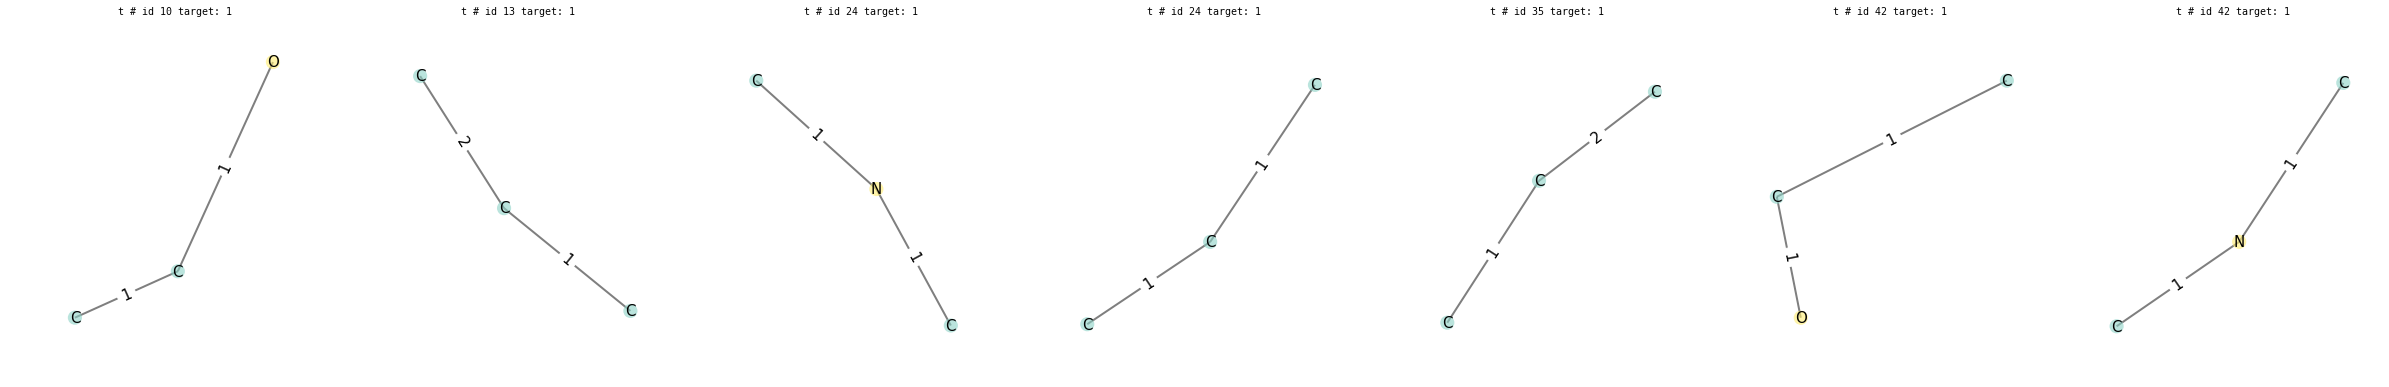

cluster id: 5  num: 43


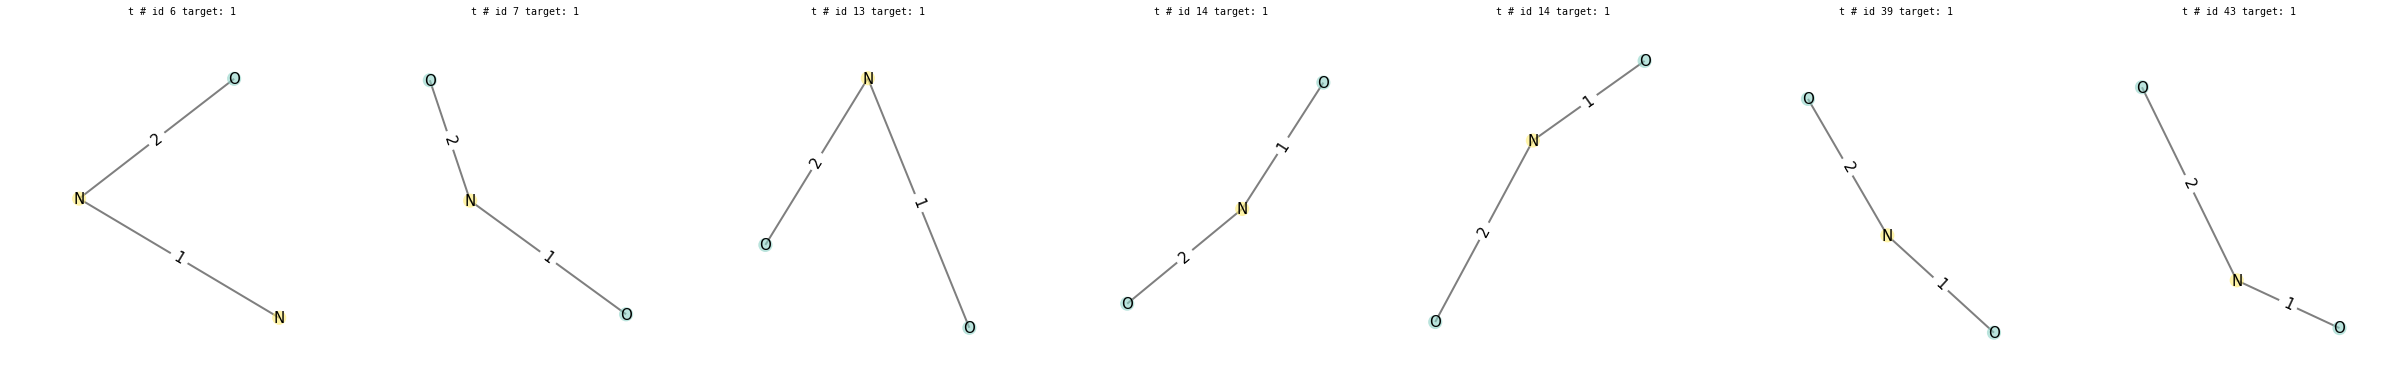

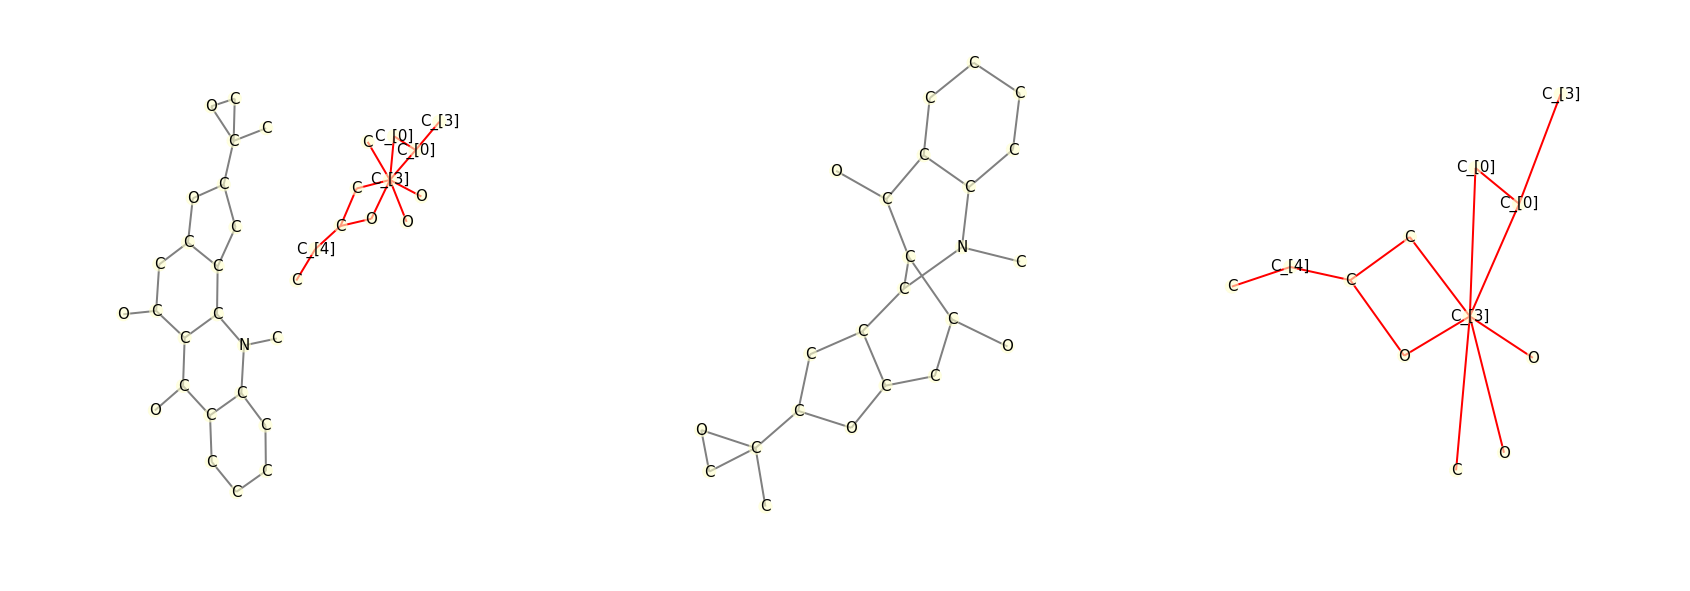

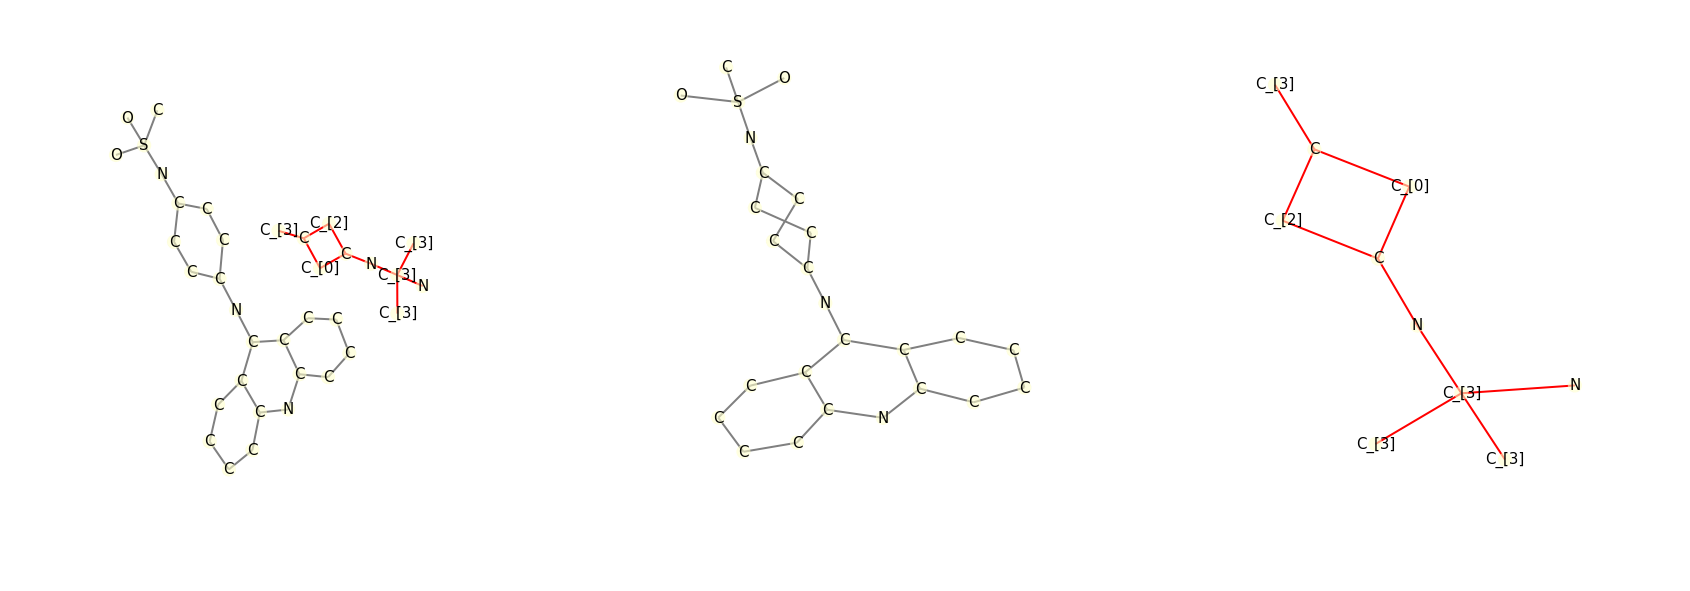

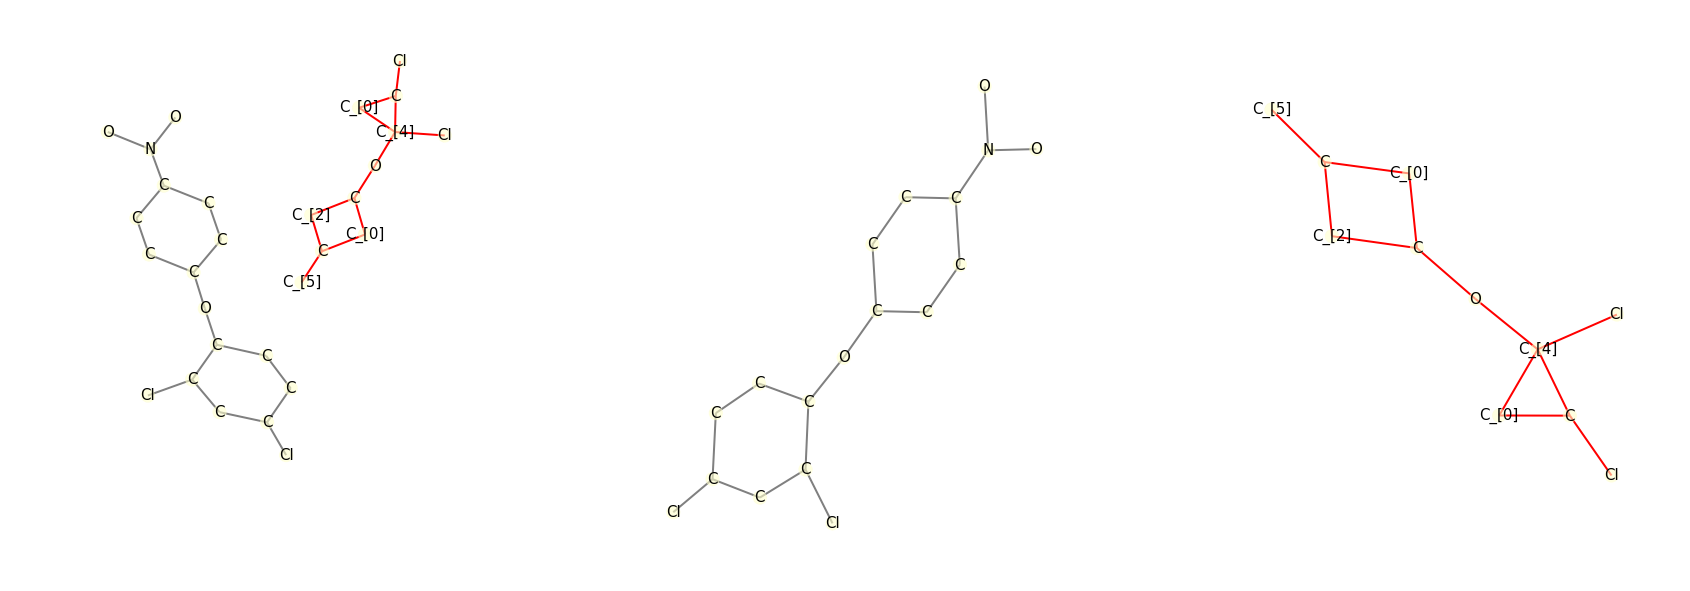

In [22]:

from graphlearn.utils import draw
import graphlearn.abstract_graphs.learned as learn
from eden.graph import Vectorizer

#preparing
v=Vectorizer(complexity=3)
pp=learn.PreProcessor(kmeans_clusters=4,learned_node_names_clusters=6, save_graphclusters=True)
pp.set_param(v)

# the magic happens here
wrappers=pp.fit_transform(get_graphs(size=100))

# lets look at some clusters
for cluster_id in pp.graphclusters:
    print('cluster id: %d  num: %d' % (cluster_id, len(pp.graphclusters[cluster_id])))
    if cluster_id != -1:
        draw.graphlearn(pp.graphclusters[cluster_id][:7], n_graphs_per_line=7, 
                        size=6, vertex_color='_label_', prog='neato', colormap='Set3',
                        contract=False,edge_label='label')


#lets draw what we did there
for i in range(3):
    draw.graphlearn([wrappers[i+5].graph(),wrappers[i+5].base_graph(),wrappers[i+5].abstract_graph()],
                    size=10,
                    contract=True, 
                    abstract_color='red',
                    vertex_label='label'
                   )



### lets see if these wrappers give us CIPS as this is their only purpose.

#### this is not interesting.

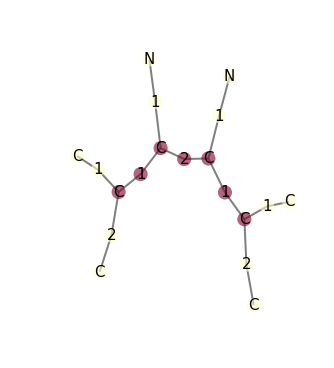

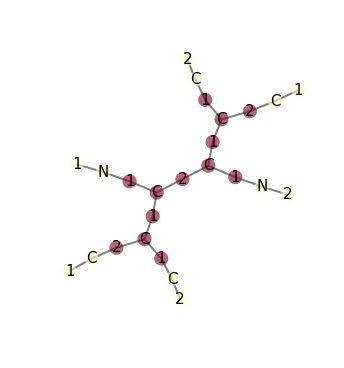

In [16]:
#parameters 
radius_list=[0,2]
thickness_list=[2,4]
base_thickness_list=[2]
#extract
cips=wrappers[0].all_core_interface_pairs(thickness_list=[2],radius_list=[0,1],hash_bitmask=2**20-1)
#draw
draw.graphlearn(cips[0][0].graph, contract=False)
draw.graphlearn(cips[0][1].graph, contract=False)


## Train sampler

In [17]:
%%time
import graphlearn.abstract_graphs.learned as learn
from graphlearn.graphlearn import Sampler as graphlearn_sampler
graphs = get_graphs(size=200)
sampler=graphlearn_sampler(radius_list=[0,1],
            thickness_list=[1], 
            min_cip_count=2, 
            min_interface_count=2, 
            preprocessor=learn.PreProcessor(base_thickness_list=[2],learned_node_names_clusters=5,kmeans_clusters=4))

sampler.fit(graphs,grammar_n_jobs=1)
print 'done'



done
CPU times: user 41 s, sys: 1 s, total: 42 s
Wall time: 49.3 s


## Inspect the induced grammar

interface id: 427728 [28 options]


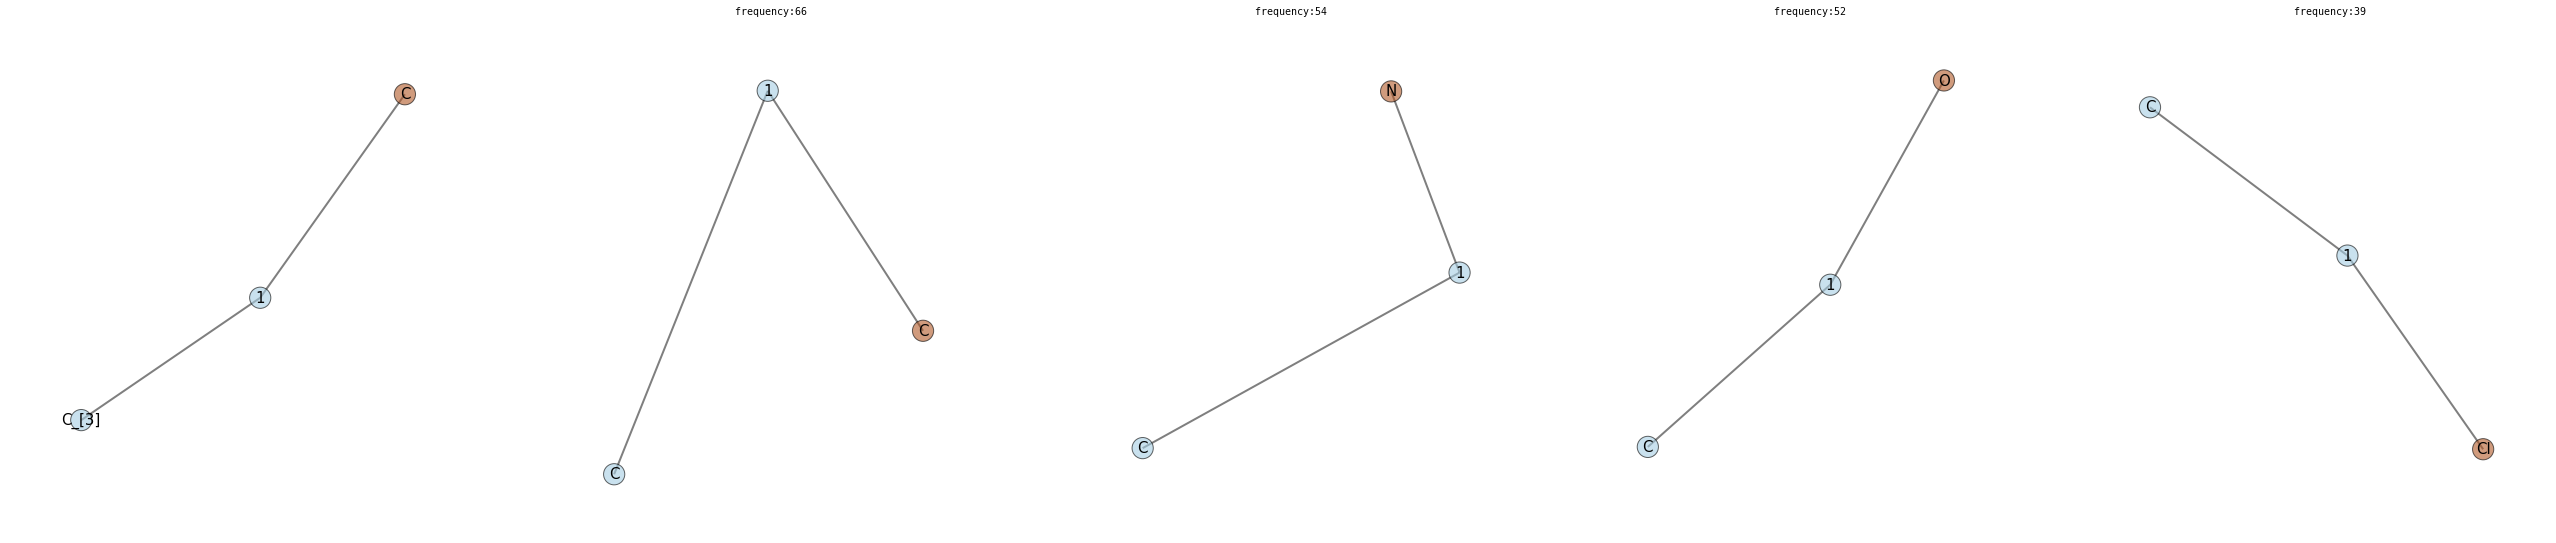

interface id: 534626 [15 options]


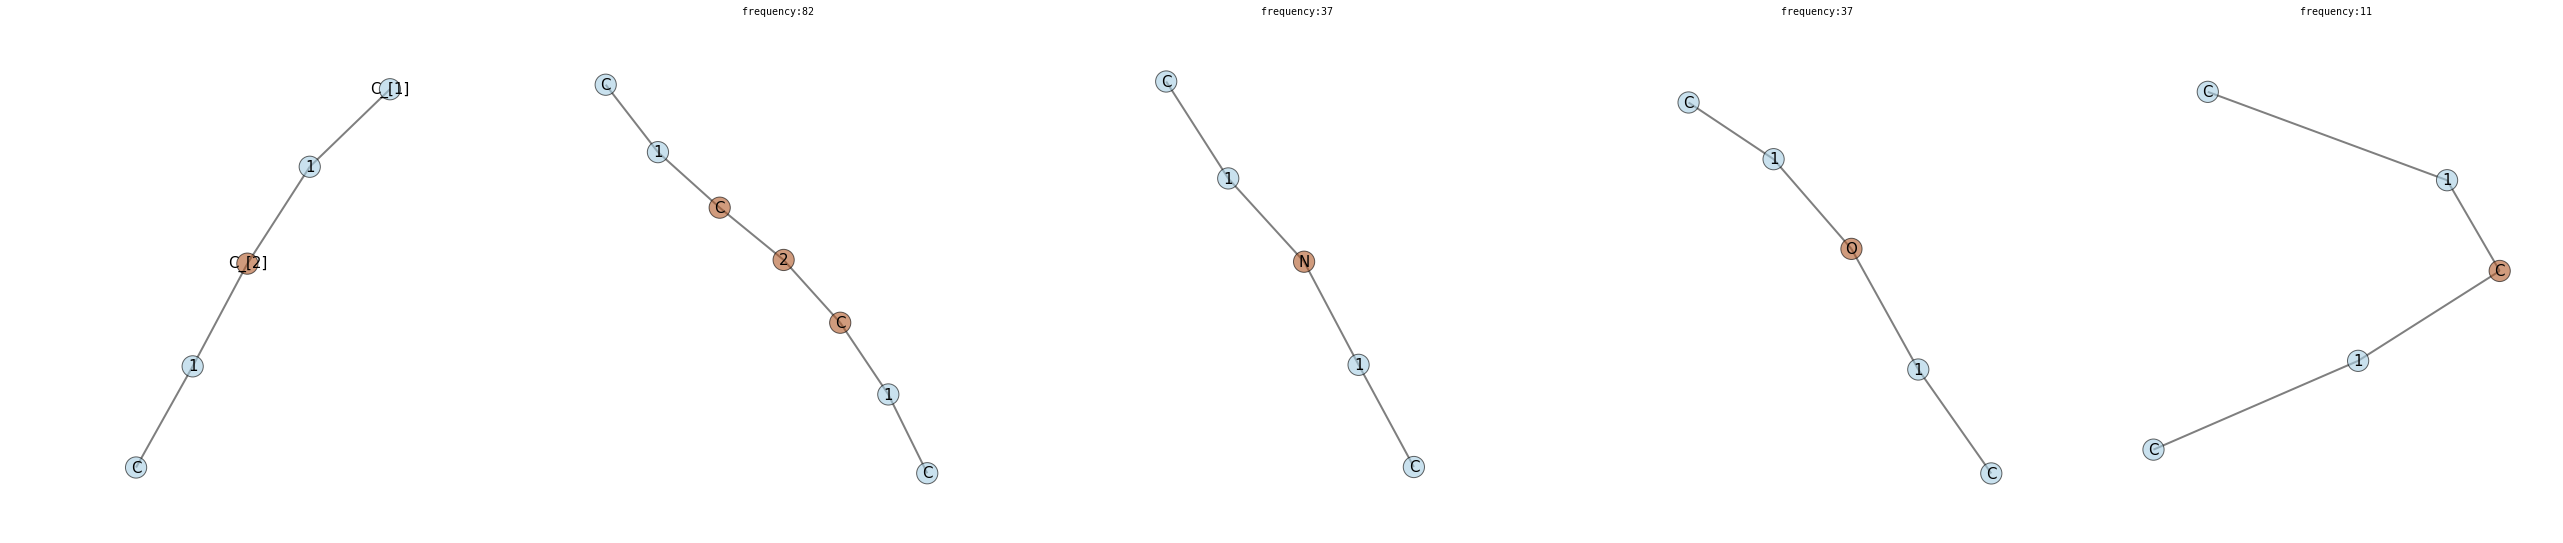

interface id: 529250 [12 options]


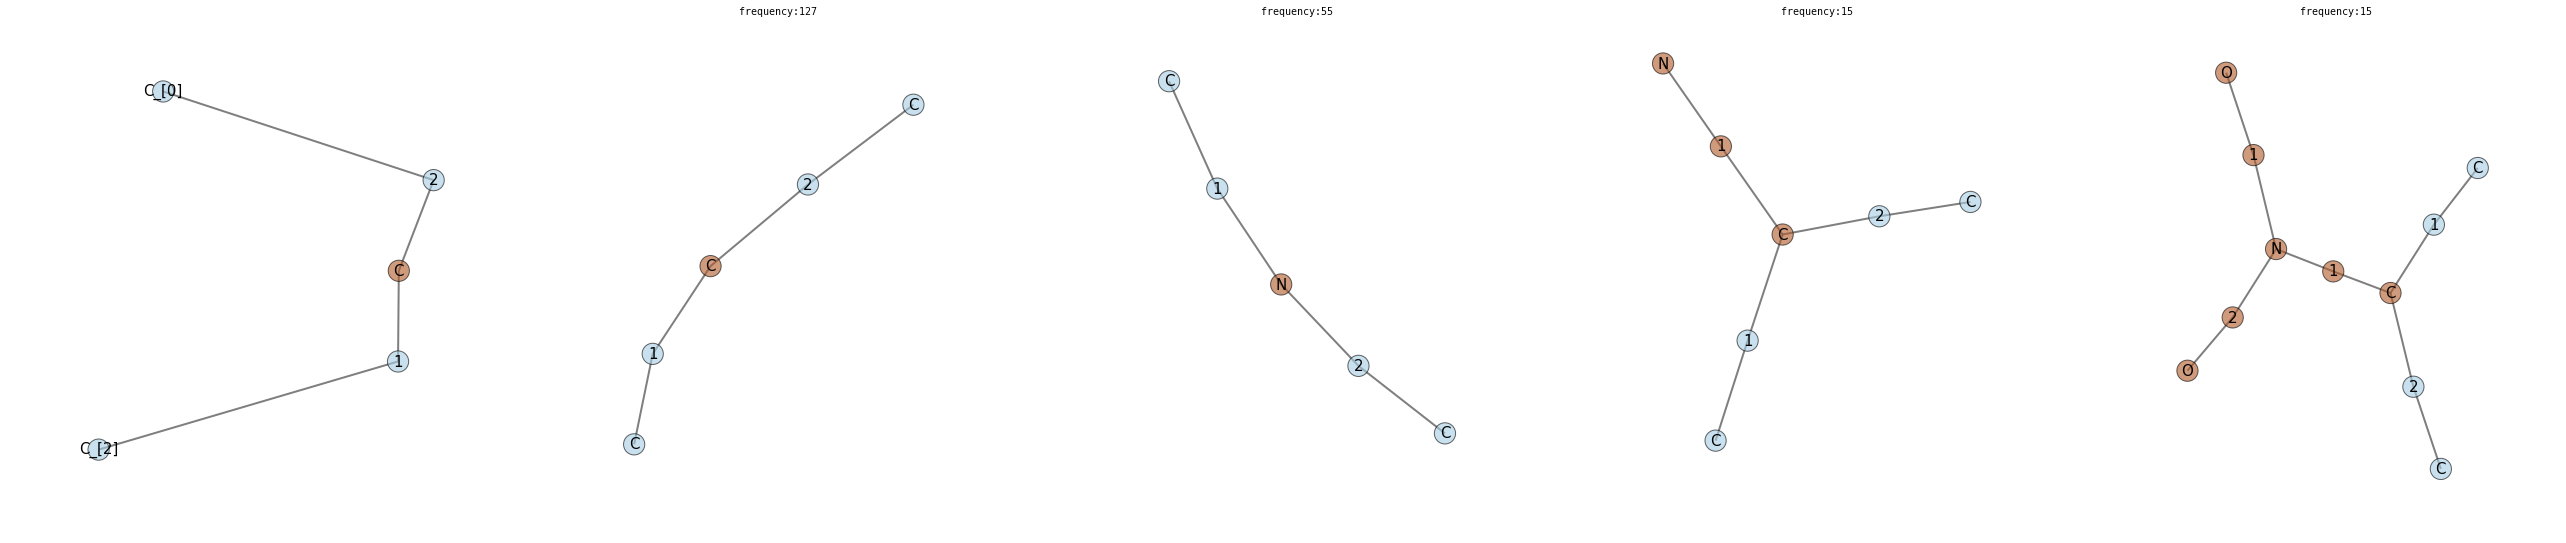

interface id: 542986 [10 options]


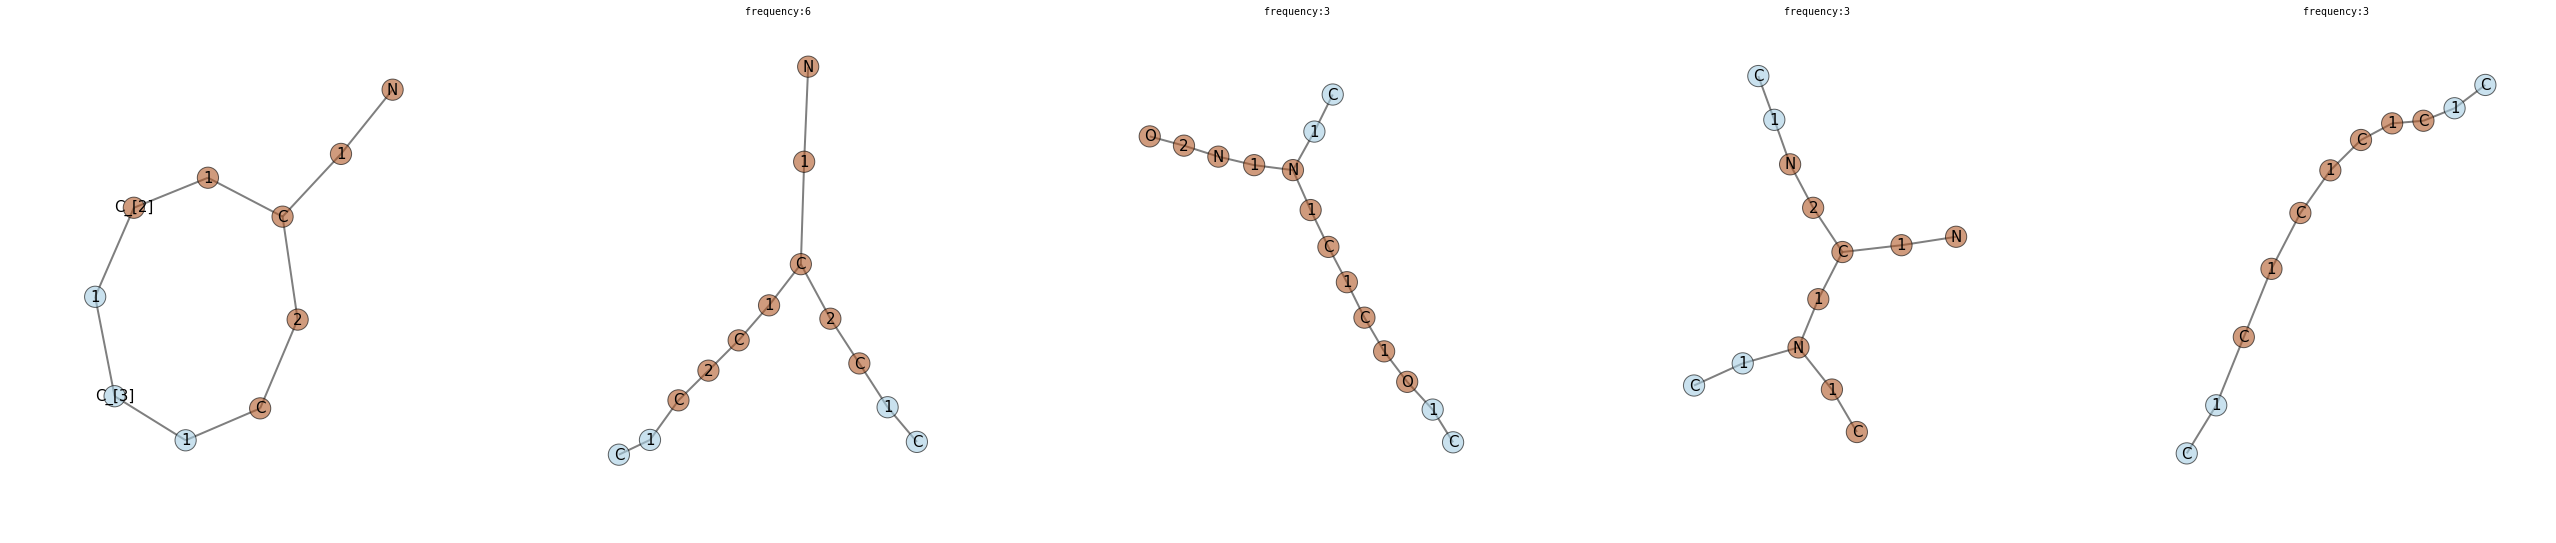

interface id: 522347 [7 options]


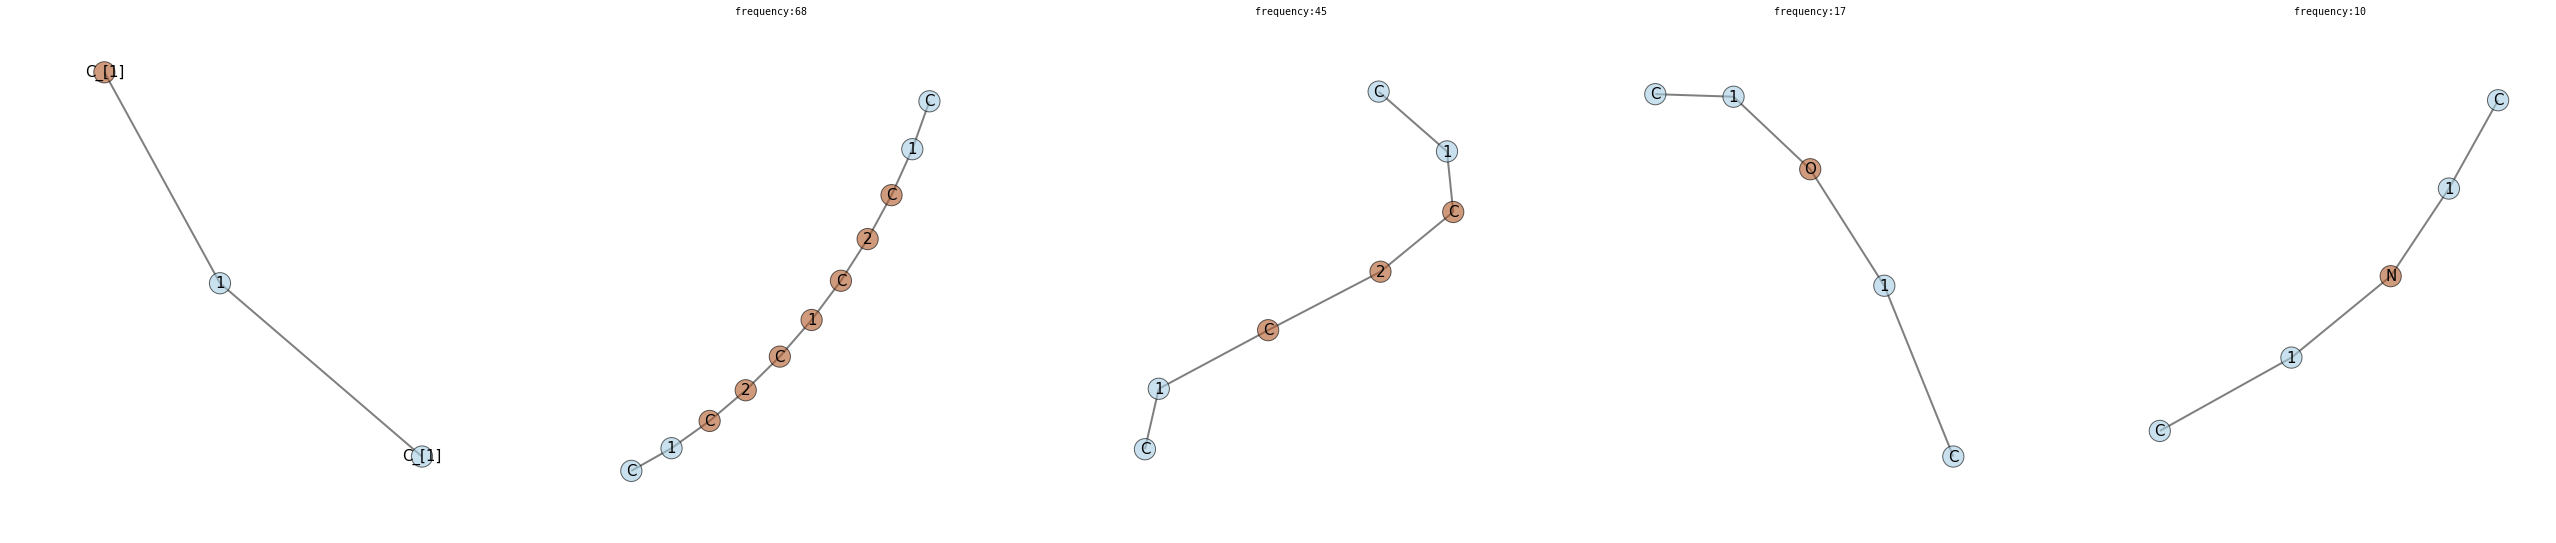

In [18]:
draw.draw_grammar(sampler.lsgg.productions,n_productions=5,n_graphs_per_production=5,
                     n_graphs_per_line=5, size=9, contract=False,
                     colormap='Paired', invert_colormap=False,node_border=1,
                     vertex_alpha=0.6, edge_alpha=0.5, node_size=450, abstract_interface=True)

## sample molecules

Graph id: 15


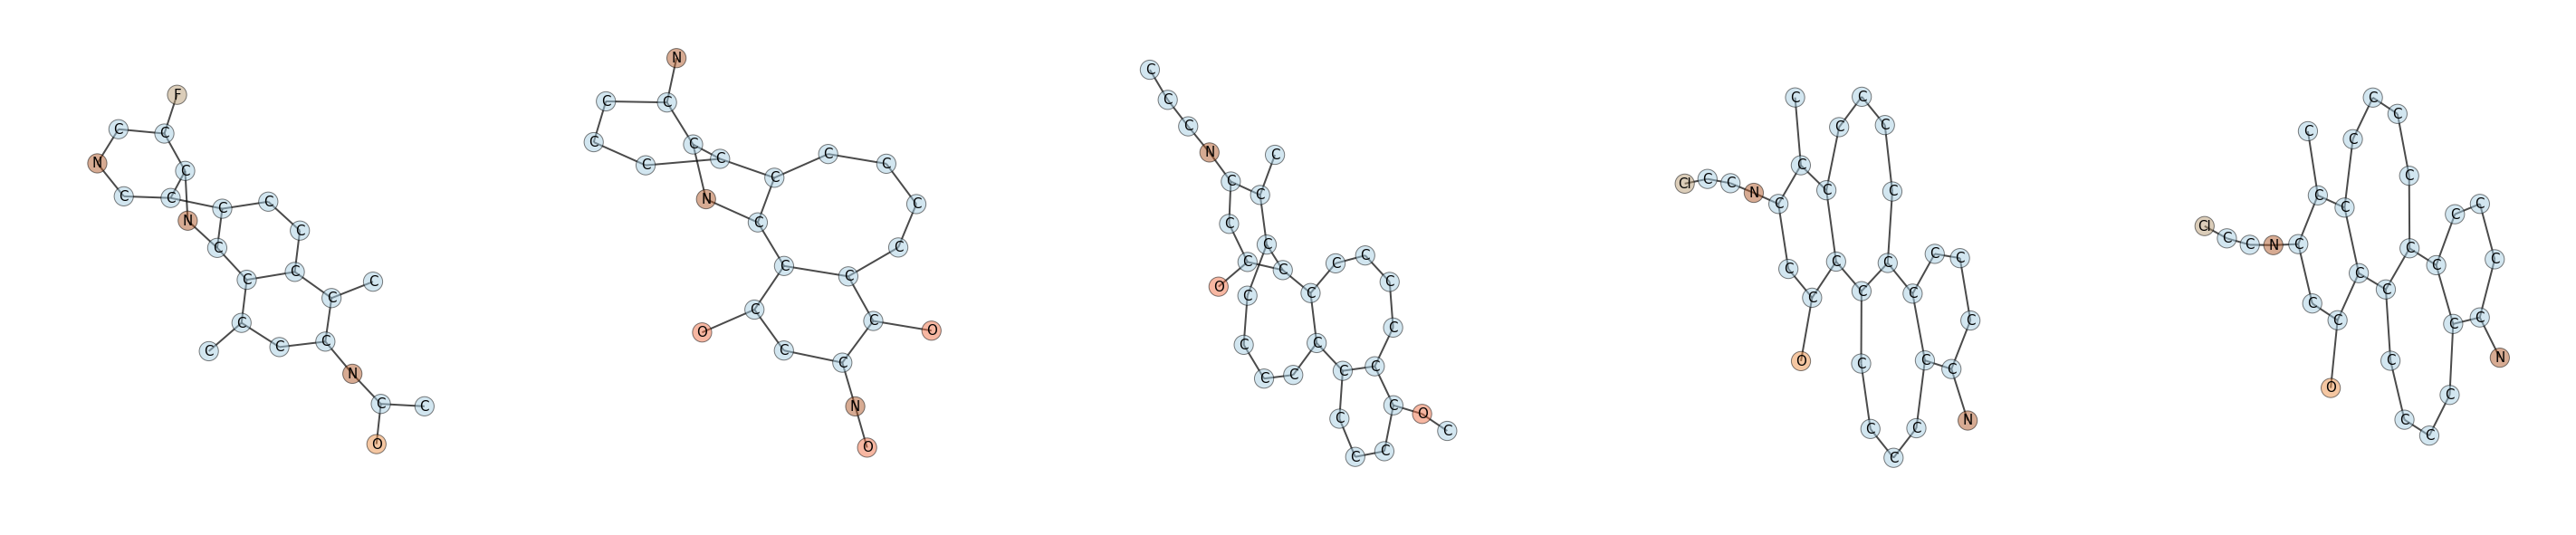

Graph id: 16


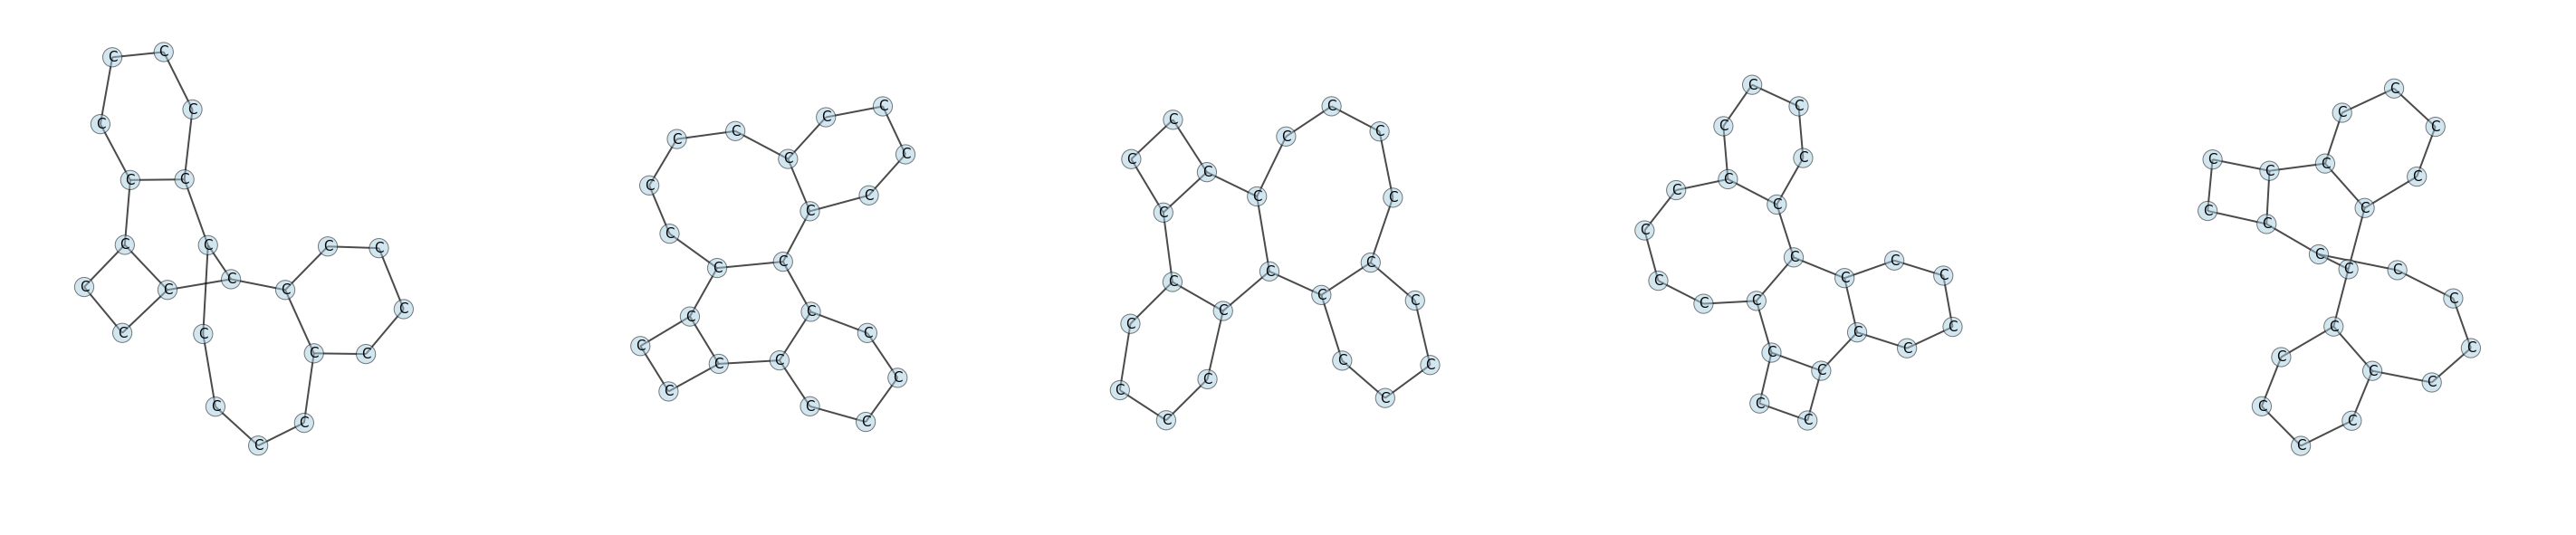

Graph id: 17


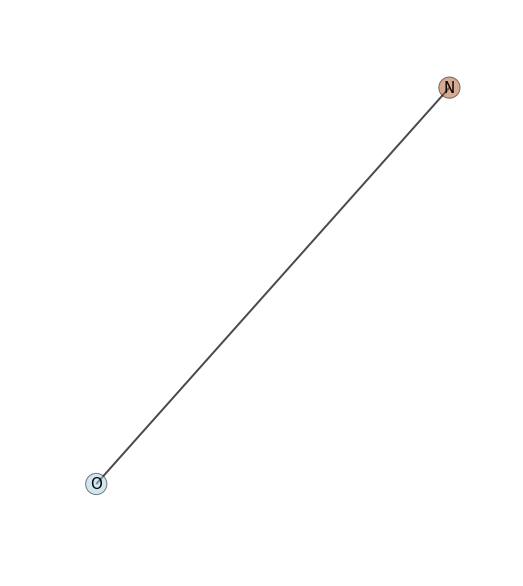

Graph id: 18


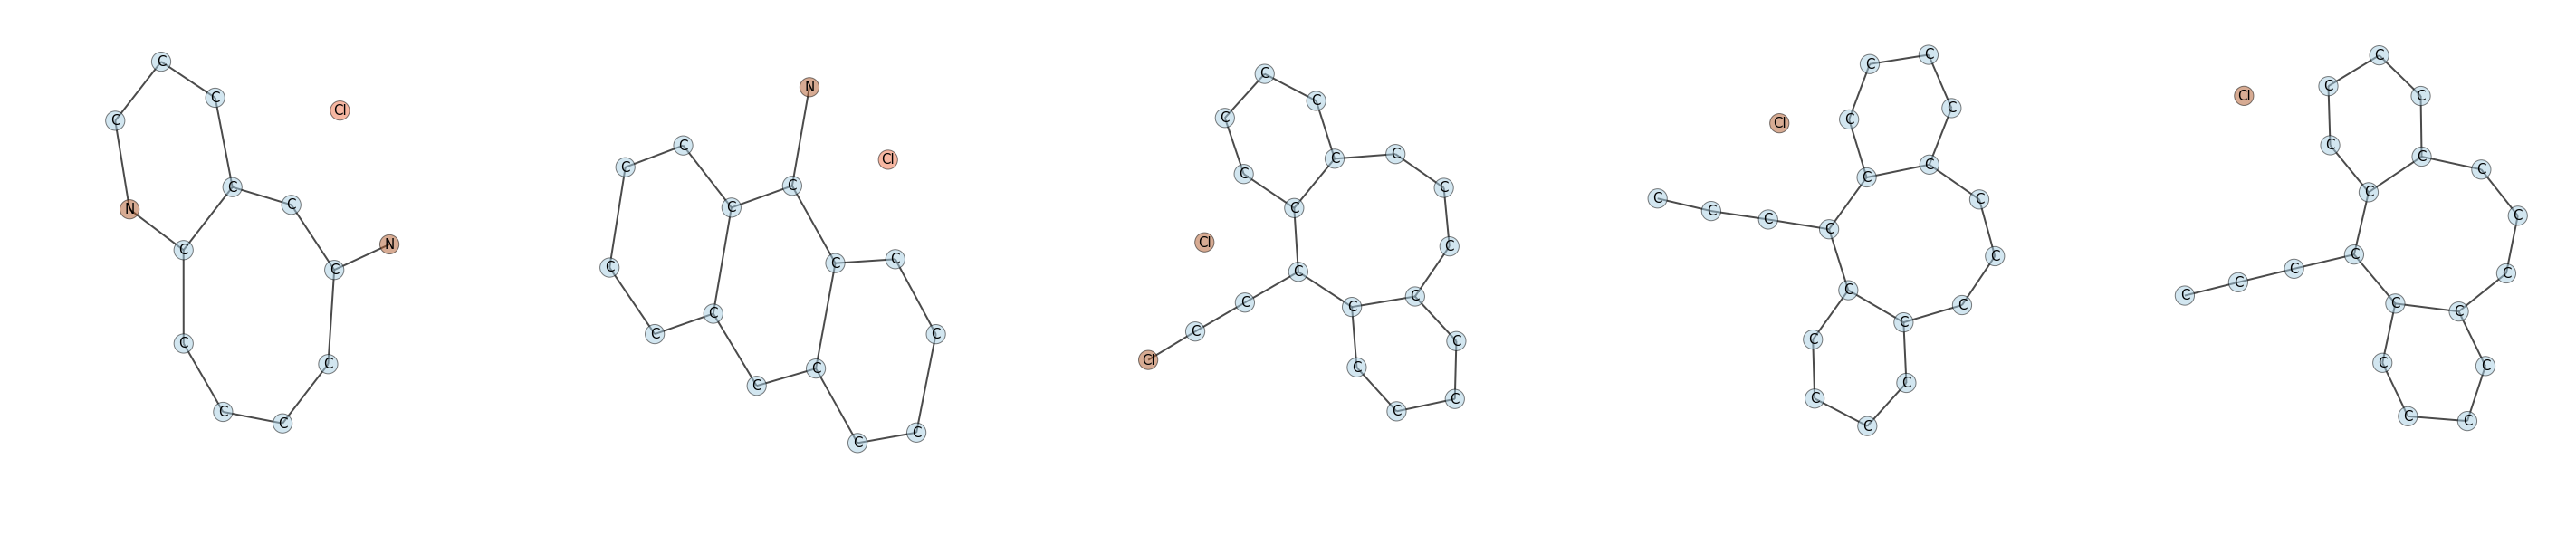

Graph id: 19


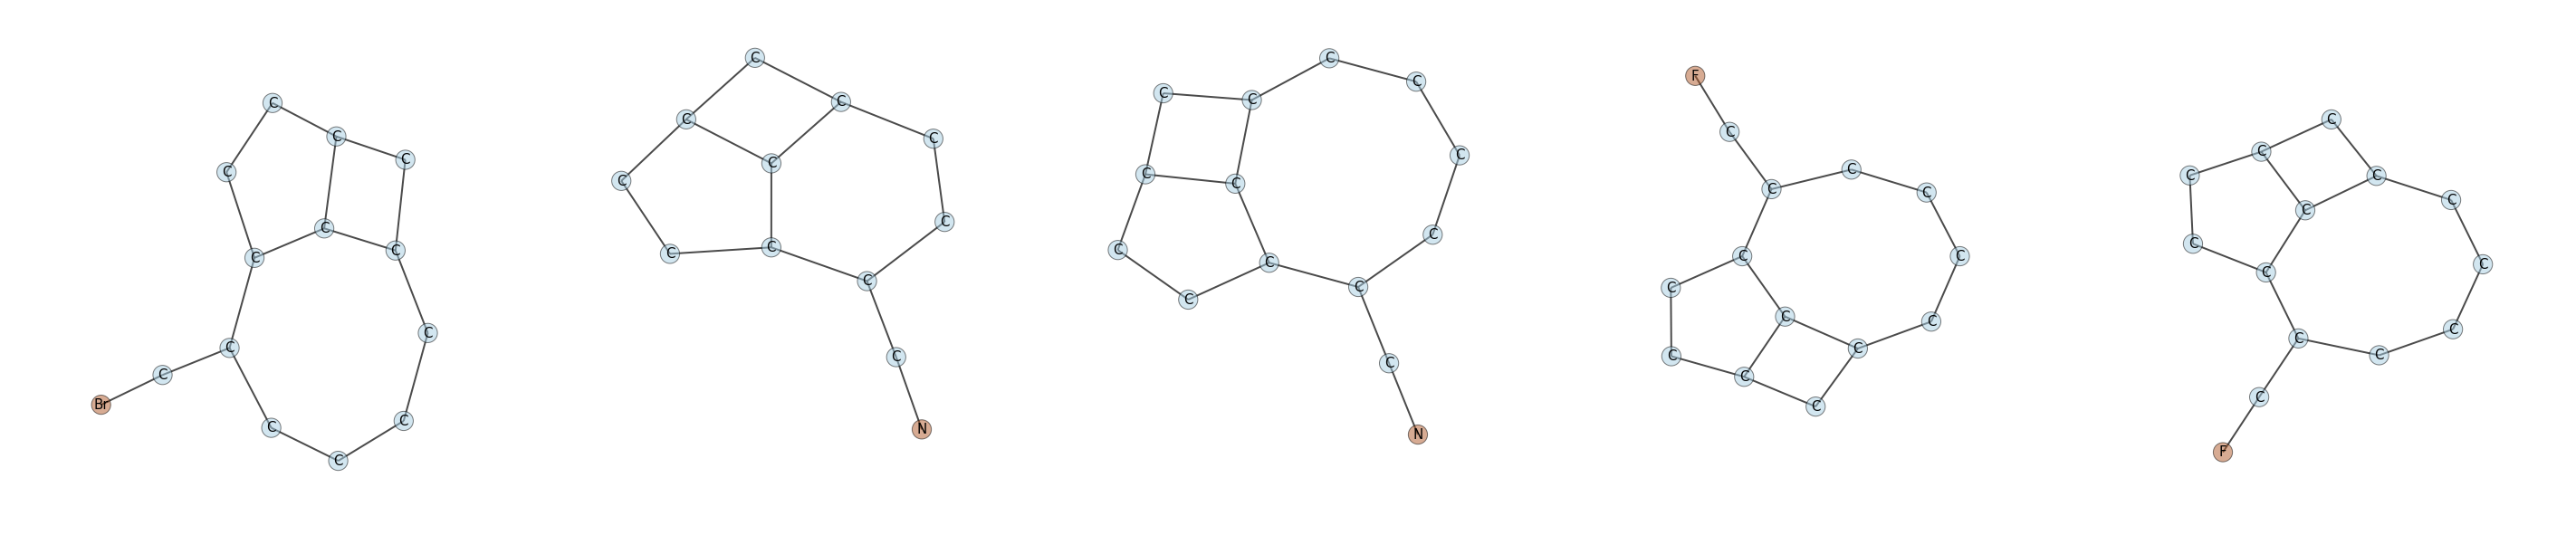

Graph id: 20


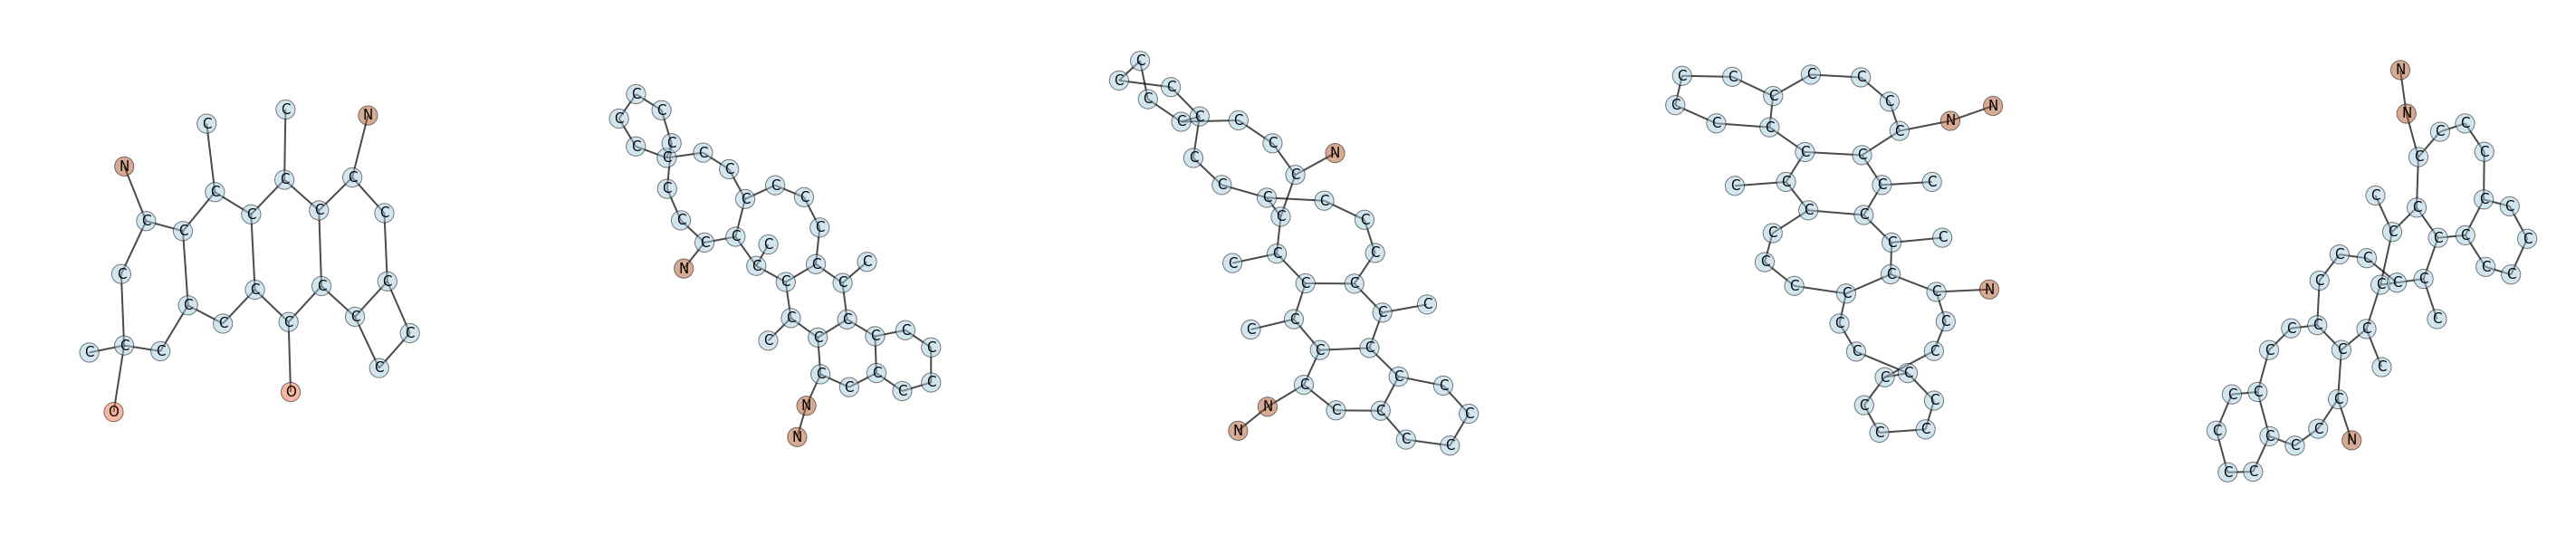

Graph id: 21


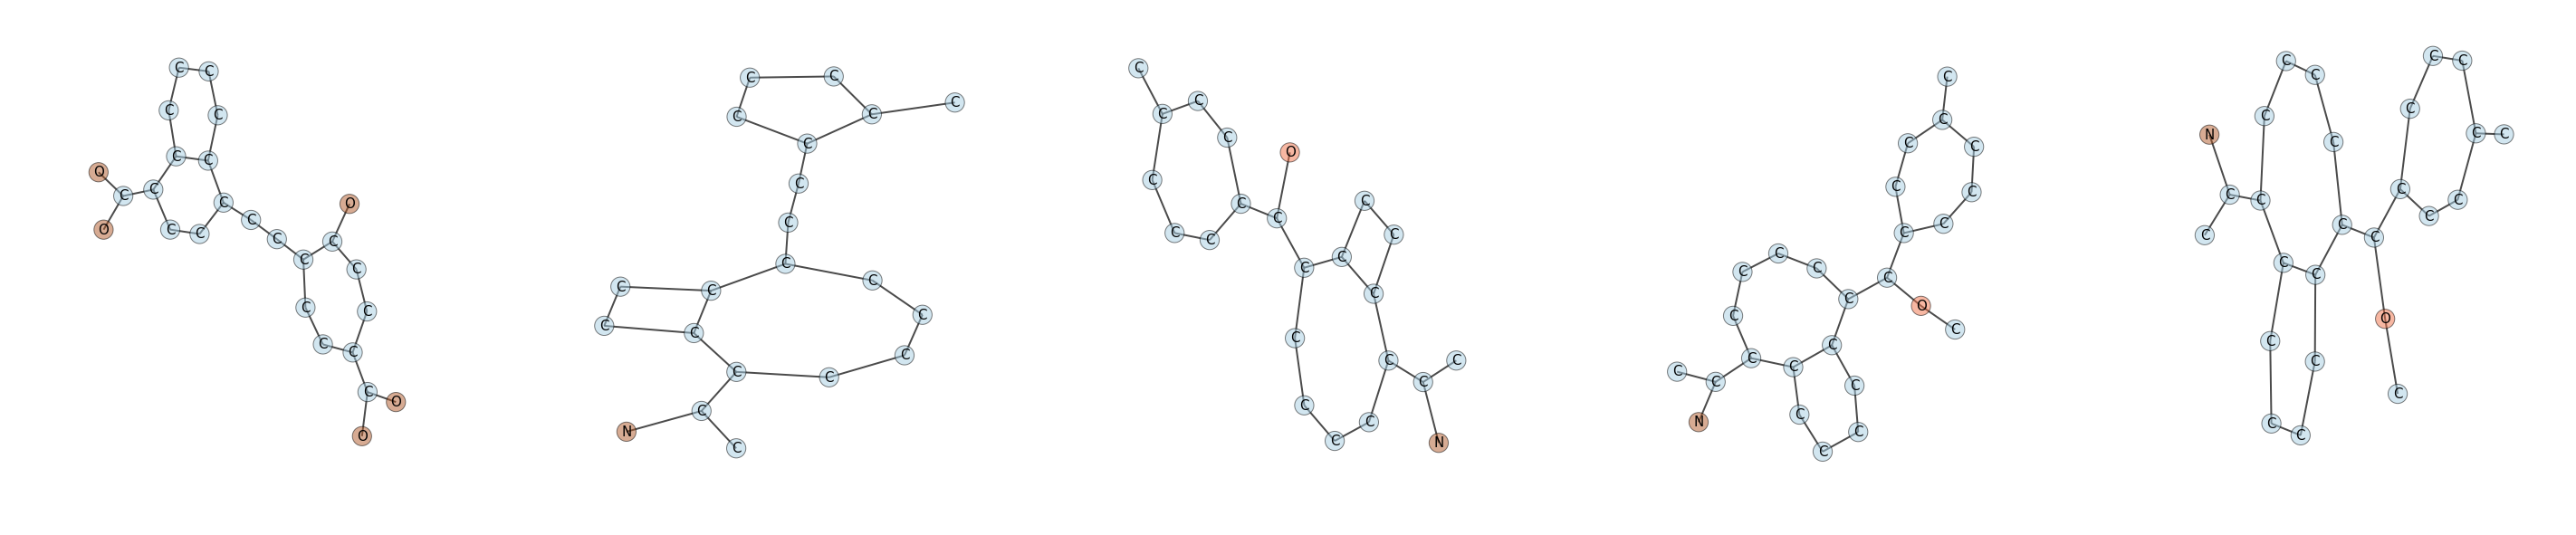

Graph id: 22


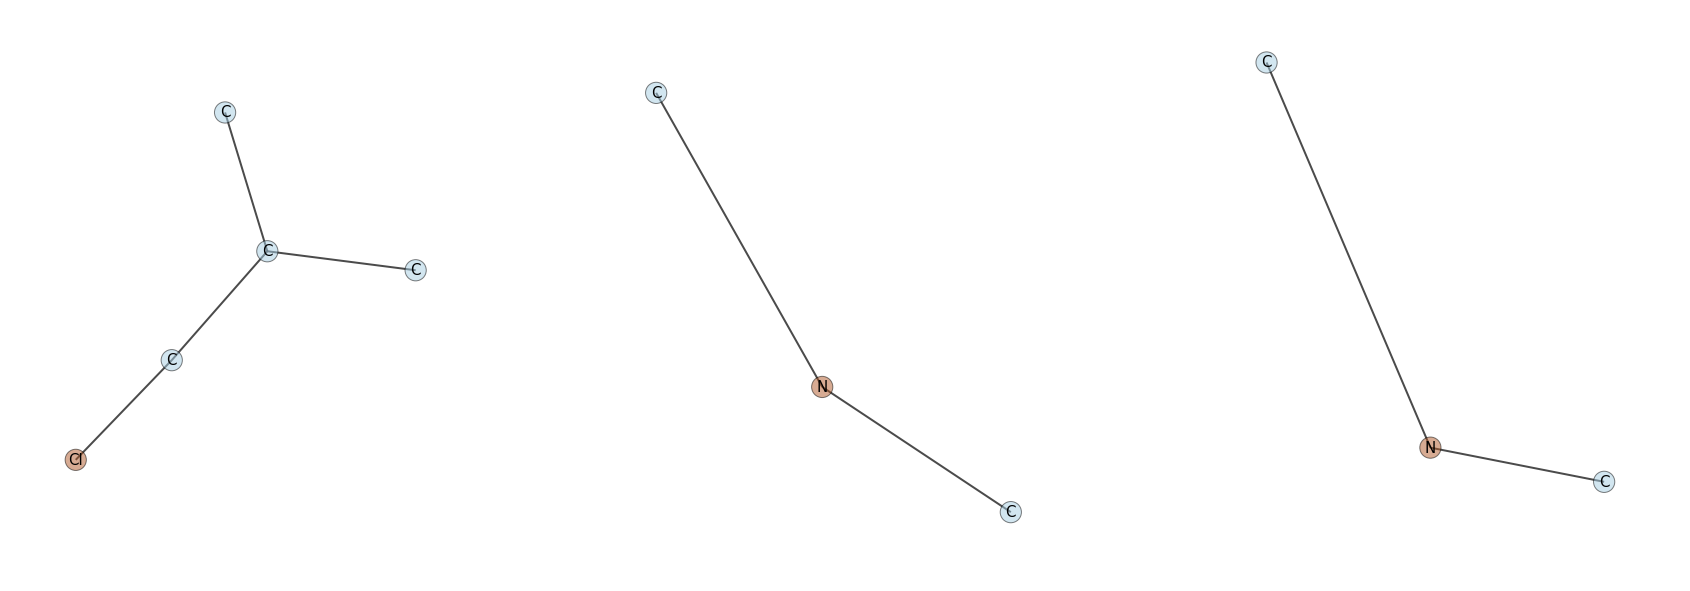

Graph id: 23


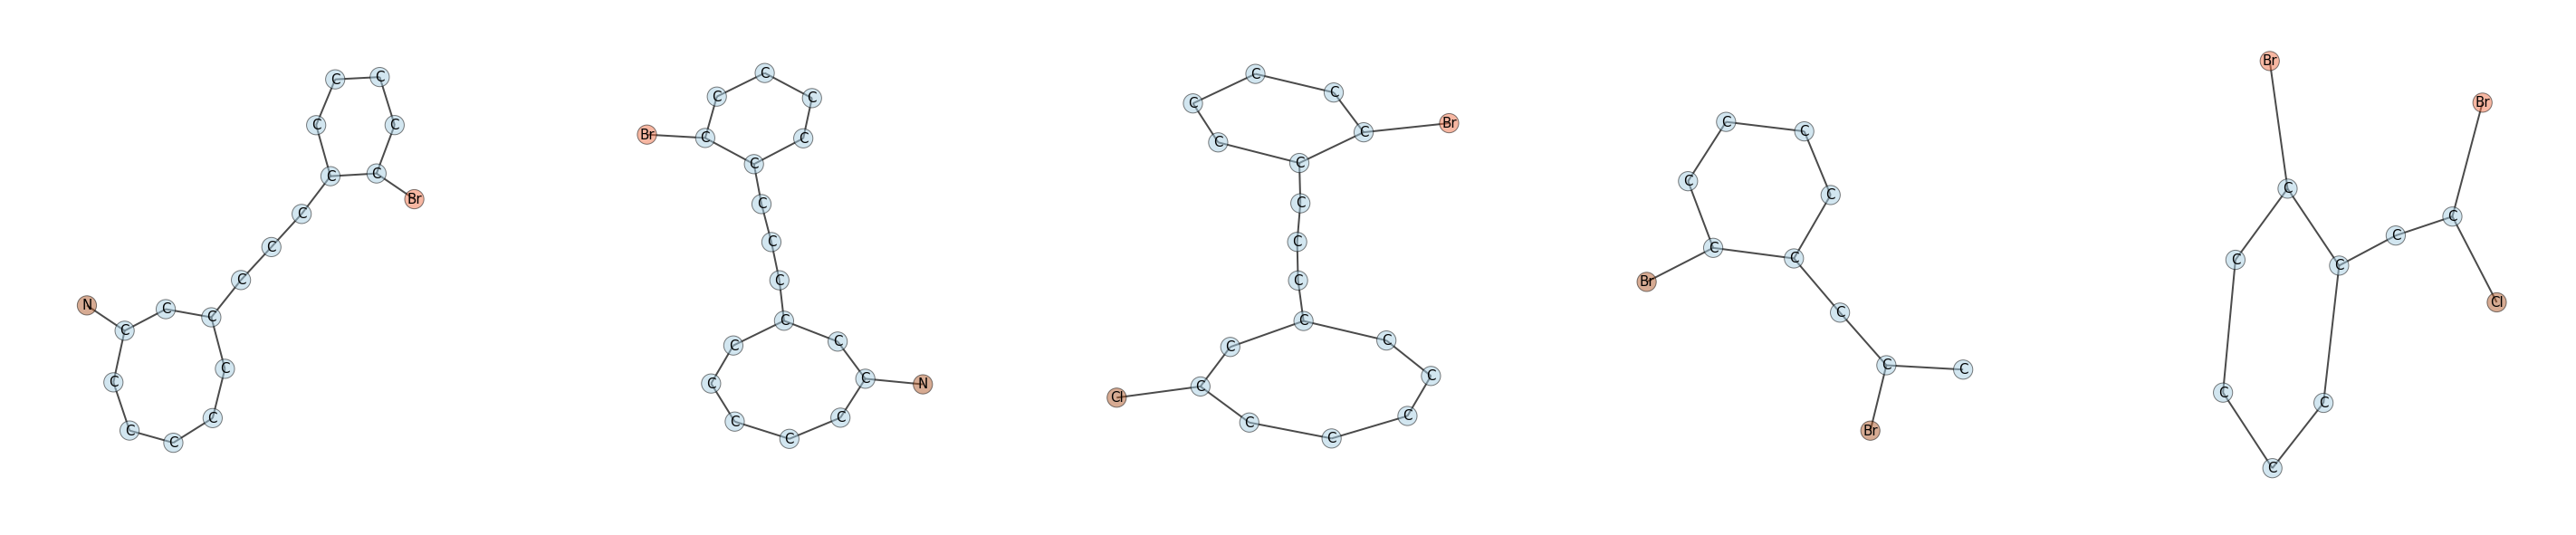

CPU times: user 31.1 s, sys: 516 ms, total: 31.7 s
Wall time: 32.4 s


In [19]:
%%time
import graphlearn.utils.draw as draw
import itertools

#parameters
graphs = get_graphs()
id_start=15
id_end=id_start+9
graphs = itertools.islice(graphs,id_start,id_end)
n_steps=50


# sampling with many arguments.
graphs = sampler.sample(graphs,
                        n_samples=5,
                        batch_size=1,
                        n_steps=n_steps,
                        n_jobs=1,
                        quick_skip_orig_cip=False,
                        probabilistic_core_choice=True,
                        burnin=0,
                        improving_threshold=0.5,
                        select_cip_max_tries=100,
                        keep_duplicates=True,
                        include_seed=True)

 
    
scores=[]
ids=range(id_start,id_end)
for i,path_graphs in enumerate(graphs):
    # for each sampling path:
    print 'Graph id: %d'%(ids[i])
    
    #collect scores so that we can display the score graph later 
    scores.append(sampler.monitors[i].sampling_info['score_history'])
    
    # show graphs
    draw.graphlearn(path_graphs,
                    n_graphs_per_line=5, size=10, 
                    colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='_label_',
                    vertex_alpha=0.5, edge_alpha=0.7, node_size=450)    

## plot score graph

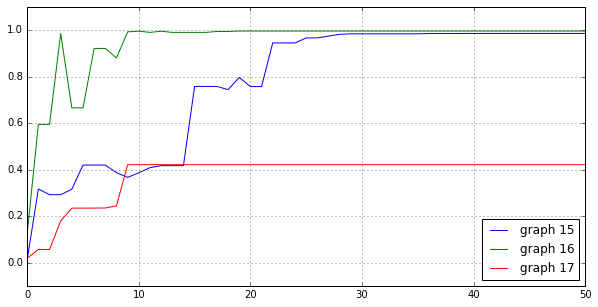

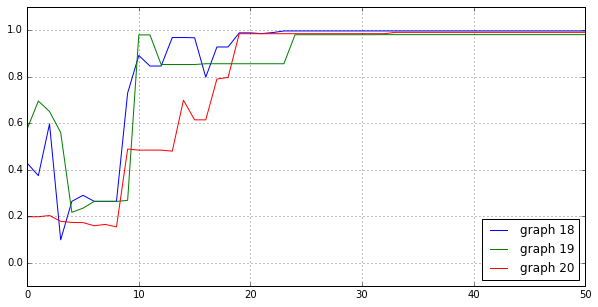

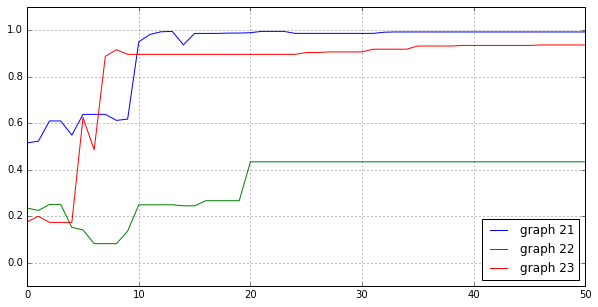

In [20]:
%matplotlib inline
from itertools import islice
import numpy as np
import matplotlib.pyplot as plt

step=1
num_graphs_per_plot=3
num_plots=np.ceil([len(scores)/num_graphs_per_plot])
for i in range(num_plots):
    plt.figure(figsize=(10,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
        data = list(islice(score,None, None, step))
        plt.plot(data, label='graph %d'%(j+i*num_graphs_per_plot+id_start))
    plt.legend(loc='lower right')
    plt.grid()
    plt.ylim(-0.1,1.1)
    plt.show()

---